# Solution to Homework 3

In [1]:
import numpy as np
import pandas as pd

from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import Word2Vec

import sys
sys.path.append('../numpy')
from common.trainer import Trainer
from common.optimizer import Adam
from common.layers import (Affine, ReLU, SoftmaxWithLoss)

In [2]:
class ReLU_FNN:
    '''
    Feedforward neural network with ReLU activation
    '''
    def __init__(self, input_size, hidden_sizes, output_size):
        I, H, O = input_size, hidden_sizes, output_size
        num_layers = len(hidden_sizes) + 1
        W_list = {}
        b_list = {}
        # random normal generator
        rn = np.random.randn

        for i in range(num_layers):
            if i != num_layers - 1:
                W_list['W' + str(i+1)] = rn(I, H[i])/np.sqrt(I)
                b_list['b' + str(i+1)] = np.zeros(H[i])
                I = H[i]
            else:
                W_list['W' + str(i+1)] = rn(H[i-1], O)/np.sqrt(H[i-1])
                b_list['b' + str(i+1)] = np.zeros(O)
        
        self.layers = []
        for i in range(1, num_layers):
            self.layers.append(Affine(W_list['W' + str(i)], 
                                      b_list['b' + str(i)]))
            self.layers.append(ReLU())
        self.layers.append(Affine(W_list['W' + str(num_layers)], 
                                  b_list['b' + str(num_layers)]))
        self.loss_layer = SoftmaxWithLoss()

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        '''
        predict scores
        '''
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        '''
        put scores in the softmax function and the cross entropy error loss
        '''
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [4]:
use_all = False

if use_all:
    train_dataset = pd.read_csv('yelp/train.csv')
    test_dataset = pd.read_csv('yelp/test.csv')

    train_dataset.columns = ['rating', 'review']
    test_dataset.columns = ['rating', 'review']

if not use_all:
    train_dataset = pd.read_csv('yelp/train_light.csv')
    test_dataset = pd.read_csv('yelp/test_light.csv')

In [5]:
tokens = []
filtered_tokens = []
# mask to filter out empty reviews
mask = np.array([True] * len(train_dataset))

for i, doc in enumerate(train_dataset['review']):
    token = simple_preprocess(doc)
    tokens.append(token)
    if len(token) > 0:
        filtered_tokens.append(token)
    else:
        mask[i] = False

# filter out empty reviews
train_df = train_dataset[mask]

In [6]:
test_tokens = []
test_filtered_tokens = []
test_mask = np.array([True] * len(test_dataset))

for i, doc in enumerate(test_dataset['review']):
    token = simple_preprocess(doc)
    test_tokens.append(token)
    if len(token) > 0:
        test_filtered_tokens.append(token)
    else:
        test_mask[i] = False

test_df = test_dataset[test_mask]

In [7]:
train_df.shape, test_df.shape

((45494, 3), (9749, 3))

In [8]:
dictionary = corpora.Dictionary(filtered_tokens)
dictionary.add_documents([['<UNK>']])

vocab = list(dictionary.token2id.keys())

In [9]:
embedding_dim = 100
model = Word2Vec(sentences=filtered_tokens, 
                 vector_size=embedding_dim,
                 window=5, 
                 min_count=1, 
                 workers=4,
                 sg=0)
# sg=0: CBOW, sg=1: skip-gram

In [10]:
# the special token '<UNK>' does not have a vector representation in the model
vocab[-1]

'<UNK>'

In [11]:
embeddings = [model.wv[word] for word in vocab[:-1]]
embeddings.append(np.zeros(embedding_dim))
embeddings = np.array(embeddings)
embeddings.shape

(56277, 100)

In [12]:
X = np.array([embeddings[dictionary.doc2idx(token)].mean(axis=0)
              for token in filtered_tokens])
Y = np.array(train_df.rating)
t = np.zeros((len(Y), 5))
for i, y in enumerate(Y):
    t[i, y-1] = 1

X.shape, Y.shape, t.shape

((45494, 100), (45494,), (45494, 5))

In [13]:
X_test = np.array([embeddings[dictionary.doc2idx(token)].mean(axis=0)
                   for token in test_filtered_tokens])
Y_test = np.array(test_df.rating)
t_test = np.zeros((len(Y_test), 5))
for i, y in enumerate(Y_test):
    t_test[i, y-1] = 1

X_test.shape, Y_test.shape, t_test.shape

((9749, 100), (9749,), (9749, 5))

## NumPy Version

In [16]:
max_epoch = 200
batch_size = 1058
learning_rate = 0.01
max_iters = X.shape[0] // batch_size 

cls_model = ReLU_FNN(input_size=embedding_dim, 
                     hidden_sizes=[256, 128], 
                     output_size=5)
optimizer = Adam(lr=learning_rate)

| epoch 1 |  iter 1 / 43 | time 0[s] | loss 1.64
| epoch 2 |  iter 1 / 43 | time 0[s] | loss 1.29
| epoch 3 |  iter 1 / 43 | time 0[s] | loss 1.17
| epoch 4 |  iter 1 / 43 | time 1[s] | loss 1.15
| epoch 5 |  iter 1 / 43 | time 2[s] | loss 1.14
| epoch 6 |  iter 1 / 43 | time 2[s] | loss 1.12
| epoch 7 |  iter 1 / 43 | time 2[s] | loss 1.11
| epoch 8 |  iter 1 / 43 | time 3[s] | loss 1.10
| epoch 9 |  iter 1 / 43 | time 3[s] | loss 1.09
| epoch 10 |  iter 1 / 43 | time 4[s] | loss 1.08
| epoch 11 |  iter 1 / 43 | time 4[s] | loss 1.08
| epoch 12 |  iter 1 / 43 | time 5[s] | loss 1.07
| epoch 13 |  iter 1 / 43 | time 5[s] | loss 1.07
| epoch 14 |  iter 1 / 43 | time 6[s] | loss 1.06
| epoch 15 |  iter 1 / 43 | time 6[s] | loss 1.05
| epoch 16 |  iter 1 / 43 | time 7[s] | loss 1.04
| epoch 17 |  iter 1 / 43 | time 7[s] | loss 1.03
| epoch 18 |  iter 1 / 43 | time 8[s] | loss 1.02
| epoch 19 |  iter 1 / 43 | time 8[s] | loss 1.01
| epoch 20 |  iter 1 / 43 | time 8[s] | loss 1.01
| epoch 2

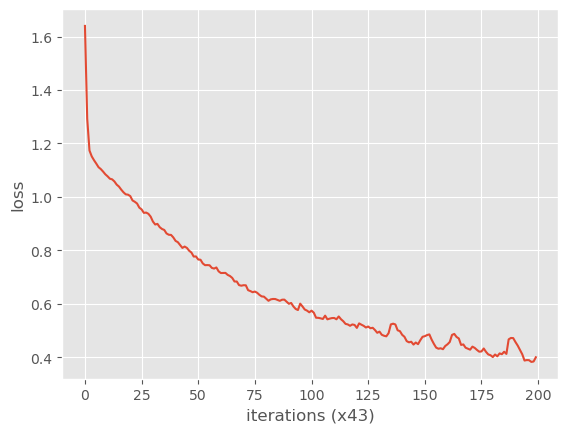

In [17]:
trainer = Trainer(cls_model, optimizer)
trainer.fit(X, t, max_epoch, batch_size, eval_interval=max_iters)
trainer.plot()

In [18]:
train_pred = np.argmax(cls_model.predict(X), axis=1)
train_label = np.argmax(t, axis=1)
train_acc = np.mean(train_pred == train_label)

print(f'Training accuracy: {train_acc * 100:.2f}%')

Training accuracy: 84.75%


In [19]:
test_pred = np.argmax(cls_model.predict(X_test), axis=1)
test_label = np.argmax(t_test, axis=1)
test_acc = np.mean(test_pred == test_label)

print(f'Test accuracy: {test_acc * 100:.2f}%')

Test accuracy: 42.75%


## Torch Version

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [21]:
tensor_x_train = torch.as_tensor(X, dtype=torch.float32)
tensor_x_test = torch.as_tensor(X_test, dtype=torch.float32)
tensor_y_train = torch.as_tensor(Y-1, dtype=torch.long)
tensor_y_test = torch.as_tensor(Y_test-1, dtype=torch.long)

In [22]:
torch.manual_seed(0)
cls_model2 = nn.Sequential(
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 5)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cls_model2 = cls_model2.to(device)

lr = 0.01
optimizer = optim.Adam(params=cls_model2.parameters(), lr=lr)
ce_loss = nn.CrossEntropyLoss()

train_data = TensorDataset(tensor_x_train, tensor_y_train)
train_loader = DataLoader(train_data,
                          batch_size=1058,
                          shuffle=True, 
                          drop_last=True,
                          generator=torch.Generator().manual_seed(2024))

In [23]:
epoch = 0 
max_epochs = 200
losses = np.zeros(max_epochs)
tol = 1e-4

while epoch < max_epochs:
    loss_per_epoch = 0
    cls_model2.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = cls_model2(x_batch)
        loss = ce_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        loss_per_epoch += loss.item()
    losses[epoch] = loss_per_epoch/len(train_loader)

    # early stopping:
    # if the difference between the current loss 
    # and the average loss of the last 10 epochs
    # is less than the tolerance, stop training
    if epoch > 10 \
        and abs(losses[epoch] - np.mean(losses[epoch-10:epoch])) < tol:
        break
    epoch += 1

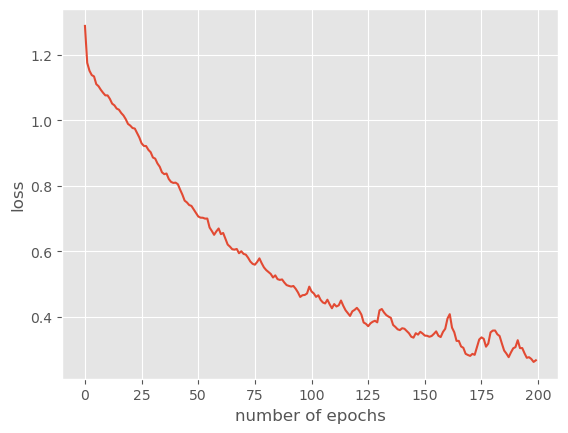

In [29]:
# plot the training losses over epochs
plt.plot(np.arange(min(epoch+1, max_epoch)), 
         losses[:epoch+1])
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show()

In [30]:
cls_model2.to('cpu')
cls_model2.eval()
train_pred = torch.argmax(cls_model2(tensor_x_train), axis=1)
train_acc = torch.mean((train_pred == tensor_y_train).float())

print(f'Training accuracy: {train_acc * 100:.2f}%')

Training accuracy: 89.32%


In [31]:
cls_model2.eval()
test_pred = torch.argmax(cls_model2(tensor_x_test), axis=1)
test_acc = torch.mean((test_pred == tensor_y_test).float())

print(f'Test accuracy: {test_acc * 100:.2f}%')

Test accuracy: 41.57%
